## EEG data of simple and compound limb motor imagery
There are ten files from ten subjects stored in three zip files: data1, data2 and data3.<br>
Each file contains EEG 'data' (Channel*Time*Trial) and labels.<br>
Data is from 64 channels. 560 trials, i.e. 560 =  80 x 7 classes each.<br>
So, eeg.shape == (64,1600,560).<br>
The data were band-pass filtered between 0.1 and 50Hz. <br>
Each EEG waveform is 8s long (1600 time points), <br>
sampling rate is 200Hz. There are 560 labels,  1-7 indicate <br>
left hand, right hand, both hands, feet, left hand combined with right foot, right hand <br>
combined with left foot and resting state respectively.<br>

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/27306 <br>


Change the accelerator from ```None``` to ```GPU```?

In [143]:
# author: peter-426

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from scipy import signal
import scipy.io

print(tf.__version__)

2.8.0


# Data Preprocessing

In [226]:
# load EEG data

mat = scipy.io.loadmat('data-motor-imagery/cl.mat')    

In [145]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])

In [146]:
header = mat['__header__']
print(header)
globals = mat['__globals__']
print(globals)

b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sun Dec 29 13:54:13 2013'
[]


In [147]:
# for key, val in mat.items():
#     print(key, val)

In [148]:
eeg_array = mat['data']
label_array  = mat['label']

In [272]:
print(eeg_array.shape)
print(type(eeg_array))

(64, 1600, 560)
<class 'numpy.ndarray'>


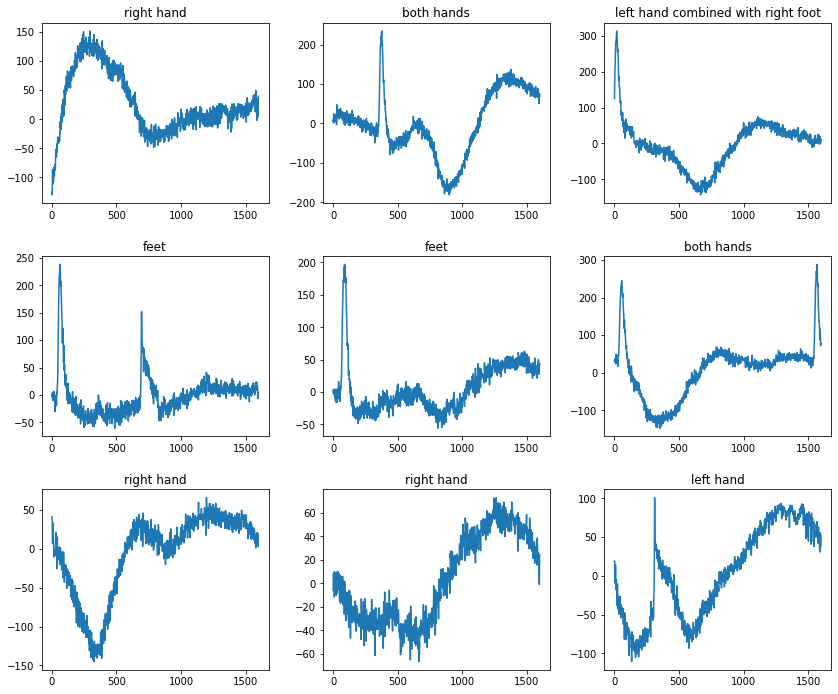

In [273]:
commands = {1:'left hand', 2:'right hand', 3:'both hands', 4:'feet', 
5:'left hand combined with right foot', 6:'right hand combined with left foot', 7:'resting state'}

plt.figure(figsize=(12,10))
for ii in range(0,9):
    plt.subplot(3,3,ii+1)
    plt.plot(eeg_array[0,:,ii])
    cmd = commands[label_array[ii,0]]
    plt.title(cmd)
plt.tight_layout(pad=2.0)

In [274]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

not_number_count=0
number_count=np.zeros(11)
    
num_rows=560 # small number, e.g. 1000, for developing code, larger number for training and testing

for hh in range(0,2):
    for ii in range(0,num_rows):

        digit = label_array[ii,0] - 1 # 7 classes were labelled 1-7, so -1.

        if digit < 0:
            not_number_count += 1
            continue
        else:
            number_count[int(digit)] += 1

        eeg = eeg_array[hh,:,ii]

        if random.random() < 0.90:
            x_train.append(eeg)
            y_train.append(digit)  
        else:
            x_test.append(eeg)
            y_test.append(digit)  

In [275]:
print("length of eeg=", len(eeg))
print("number of exampes in data set=",len(x_train))
print("training count =", len(x_train))
print("testing count =", len(x_test))
print("not number count=", not_number_count)
print("number count=", number_count)

length of eeg= 1600
number of exampes in data set= 1011
training count = 1011
testing count = 109
not number count= 0
number count= [160. 160. 160. 160. 160. 160. 160.   0.   0.   0.   0.]


In [276]:
xxx_train = np.array(x_train)
yyy_train = np.array(y_train)

xxx_test = np.array(x_test)
yyy_test = np.array(y_test)

<AxesSubplot:ylabel='count'>

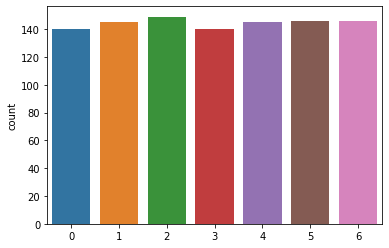

In [277]:
sns.countplot(y_train)

If similar counts for each digit, no need to downsample or upweigh.

## Check for NaN Values

In [278]:
print(np.isnan(x_train).any())
print(np.isnan(x_test).any())

False
False


## Reshaping

In [279]:
x_train=xxx_train.reshape(xxx_train.shape[0], xxx_train.shape[1],1)
x_test = xxx_test.reshape(xxx_test.shape[0], xxx_test.shape[1],1)

In [280]:
x_train.shape

(1011, 1600, 1)

In [281]:
input_shape=x_train[0].shape
print(input_shape)
output_shape=yyy_train.shape
print(output_shape)

(1600, 1)
(1011,)


## Label Encoding

Convert categorical labels to one-hot encodings.

E.g., ```2``` is ```[0,0,1,0,0,0,0,0,0,0]``` and ```7``` is ```[0,0,0,0,0,0,0,1,0,0]```.

In [282]:
y_train = tf.one_hot(yyy_train.astype(np.int32), depth=7)
y_test = tf.one_hot(yyy_test.astype(np.int32), depth=7)
print(y_train[0])
print(yyy_train[0])

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
1


# CNN

## Define the Model

In [283]:
batch_size = 32
num_classes = 7
epochs = 30

The MaxPool1D filter aims to conserve the main features of the image while reducing the size.

Dropout layers: a percent of random nodes are ignored.

```relu``` returns input value if the input value >= 0, else it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an ANN. Last layer outputs the probability that an EEG signal is in each class.

These models aims to categorize EEG signals, so it uses ```categorical_crossentropy``` loss function. 

In [284]:
model1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(32, 25, padding='same', activation='relu', input_shape=(1600,1)),
    tf.keras.layers.Conv1D(32, 25, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(), #strides=(2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [285]:
model2 = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(32, 16, padding='same', activation='relu', input_shape=(1600,1)),
    #tf.keras.layers.Conv1D(64, 16, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(32, 8, padding='same', activation='relu'),
    #tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu'),
    tf.keras.layers.MaxPool1D(strides=(1)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [286]:
# use model1

model = model1

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

## Fit the Training Data

Stop train after n epochs or when training accuracy > threshold.

Next cell defines a CallBack. If xx.x% accuracy is achieved, the model stops training. 

In [287]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')> 0.75): #0.995):
      print("\nReached xx% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [289]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

# 4. Evaluate the Model

## Accuracy Curve

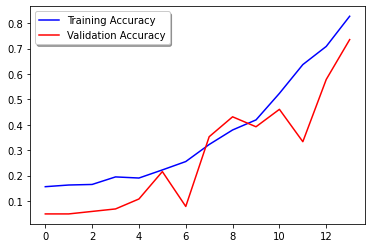

In [290]:
fig, ax = plt.subplots(1,1)
# ax[0].plot(history.history['loss'], color='b', label="Training Loss")
# ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

ax.plot(history.history['acc'], color='b', label="Training Accuracy")
ax.plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax.legend(loc='best', shadow=True)

## Predict Results

In [291]:
test_loss, test_acc = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 12ms/step - loss: 1.9883 - acc: 0.4771


## Confusion Matrix

In [292]:
# Predict the values from the test data.
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

<AxesSubplot:>

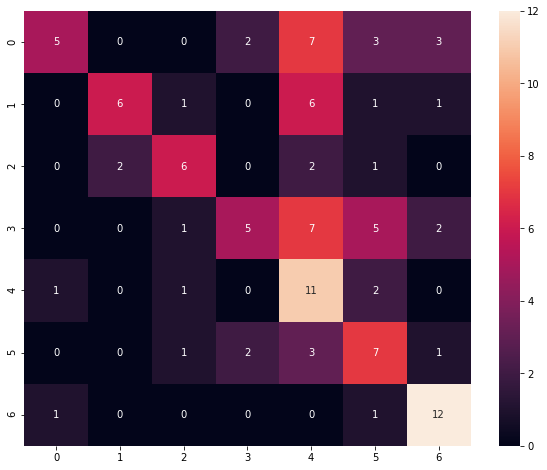

In [293]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')